# Simplest Case of Geometry Optimization

In [20]:
import drtk
import torch as th
import torch.nn.functional as thf
from PIL import Image

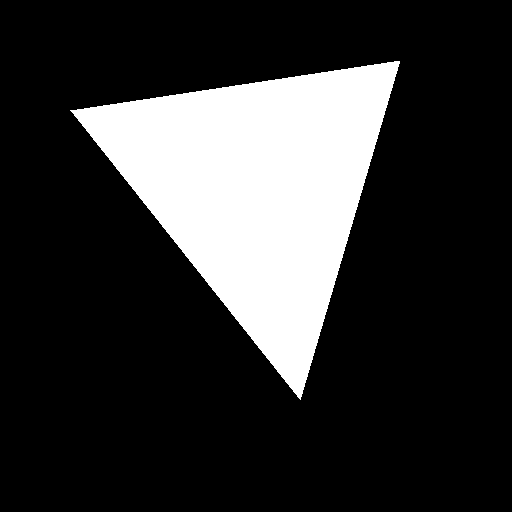

In [21]:
v = th.as_tensor(
    [[70, 110, 10], [400, 60, 10], [300, 400, 10]], dtype=th.float32
).cuda()[None]
vi = th.as_tensor([[0, 1, 2]], dtype=th.int32).cuda()

index_img = drtk.rasterize(v, vi, width=512, height=512)

image_gt = (index_img != -1).float()

Image.fromarray(image_gt[0].mul(255).clamp(min=0, max=255).byte().cpu().numpy())

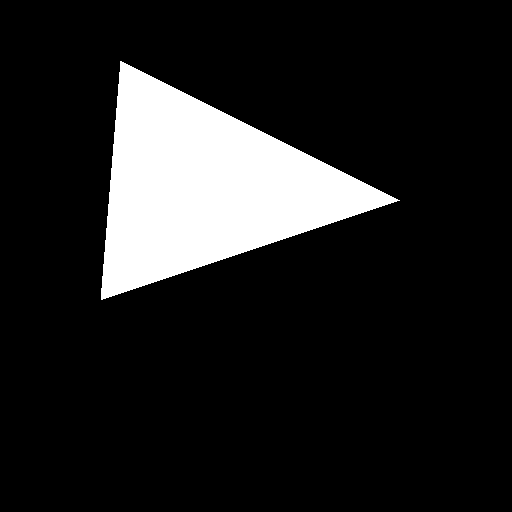

In [22]:
v = th.as_tensor(
    [[120, 60, 10], [400, 200, 10], [100, 300, 10]], dtype=th.float32
).cuda()[None]

index_img = drtk.rasterize(v, vi, width=512, height=512)
depth_img, bary_img = drtk.render(v, vi, index_img)

image = (index_img != -1).float()

Image.fromarray(image[0].mul(255).clamp(min=0, max=255).byte().cpu().numpy())

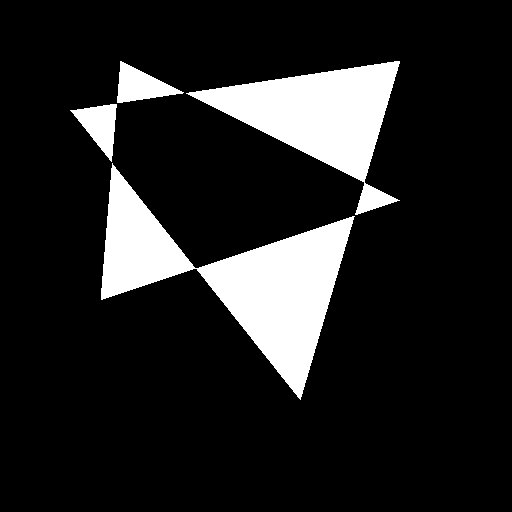

In [23]:
difference = thf.mse_loss(image, image_gt, reduction="none")

Image.fromarray(difference[0].mul(255).clamp(min=0, max=255).byte().cpu().numpy())

In [24]:
v.requires_grad_(True)
v.grad = None

tensor = []


def save_tensor(x: th.Tensor):
    tensor.append(x)


image_differentiable = drtk.edge_grad_estimator(
    v, vi, bary_img, image[:, None], index_img, v_pix_img_hook=save_tensor
)
difference = thf.mse_loss(image_differentiable, image_gt[:, None], reduction="none")
difference.sum().backward()

torch.Size([3, 512, 512])


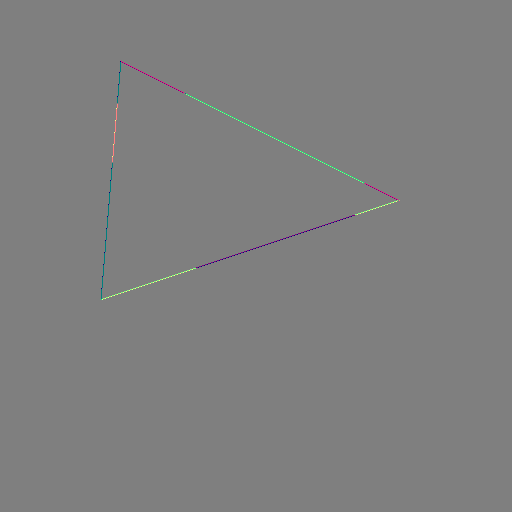

In [31]:
print(tensor[0][0].shape)
Image.fromarray(tensor[0][0].permute(1, 2, 0).mul(.5).add(0.5).mul(255).clamp(min=0, max=255).byte().cpu().numpy())